In [22]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from tqdm import tqdm  
sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(period='max')

print(sp500.tail())

del sp500["Dividends"]
del sp500["Stock Splits"]

sp500["Tomorrow"] = sp500["Close"].shift(-1)
# 1 if the price goes up, 0 if it goes down
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()
print(sp500.tail())

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.68] = 1
    preds[preds <.68] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined
def backtest(data, model, predictors, start=2500, step=20):
    all_predictions = []
    total_steps = range(start, data.shape[0], step)
    for i in tqdm(total_steps):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

horizons = [2,5,60,250,1000]
predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    predictors+= [ratio_column, trend_column]
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
print(sp500.tail())

model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

predictions = backtest(sp500, model, predictors)
print(precision_score(predictions["Target"], predictions["Predictions"]))
predictions.tail(10)


                                  Open         High          Low        Close  \
Date                                                                            
2024-02-29 00:00:00-05:00  5085.359863  5104.990234  5061.890137  5096.270020   
2024-03-01 00:00:00-05:00  5098.509766  5140.330078  5094.160156  5137.080078   
2024-03-04 00:00:00-05:00  5130.990234  5149.669922  5127.180176  5130.950195   
2024-03-05 00:00:00-05:00  5110.520020  5114.540039  5056.819824  5078.649902   
2024-03-06 00:00:00-05:00  5108.029785  5127.970215  5092.220215  5104.759766   

                               Volume  Dividends  Stock Splits  
Date                                                            
2024-02-29 00:00:00-05:00  5219740000        0.0           0.0  
2024-03-01 00:00:00-05:00  4748110000        0.0           0.0  
2024-03-04 00:00:00-05:00  4758440000        0.0           0.0  
2024-03-05 00:00:00-05:00  4418410000        0.0           0.0  
2024-03-06 00:00:00-05:00  2604927000     

100%|██████████| 511/511 [21:04<00:00,  2.47s/it]

0.6086956521739131


,Target,Predictions
Date,,
2024-02-22 00:00:00-05:00,1,0.0
2024-02-23 00:00:00-05:00,0,0.0
2024-02-26 00:00:00-05:00,1,0.0
2024-02-27 00:00:00-05:00,0,0.0
2024-02-28 00:00:00-05:00,1,0.0
2024-02-29 00:00:00-05:00,1,0.0
2024-03-01 00:00:00-05:00,0,0.0
2024-03-04 00:00:00-05:00,0,0.0
2024-03-05 00:00:00-05:00,1,0.0


<Axes: title={'center': 'Feature Importances'}>

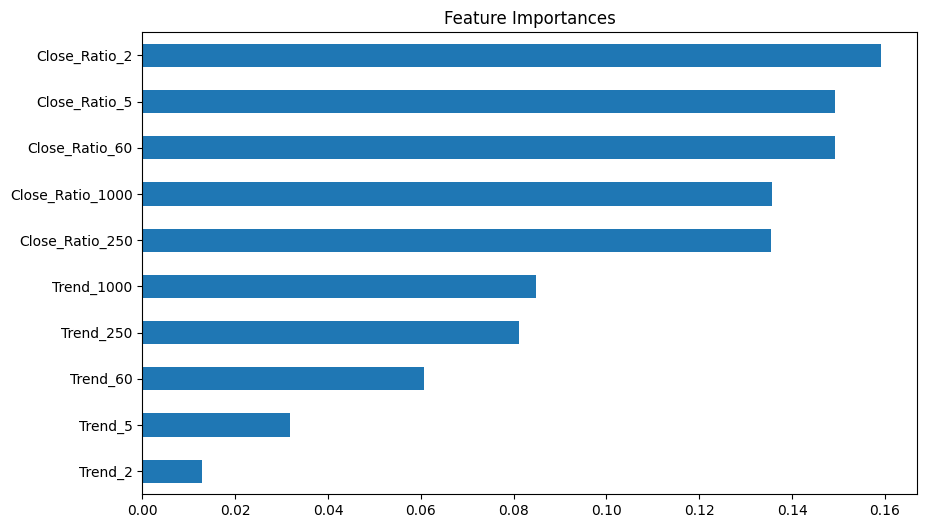

In [23]:
model.feature_importances_tree = pd.Series(model.feature_importances_, index=predictors)
model.feature_importances_tree.sort_values().plot(kind="barh", title="Feature Importances", figsize=(10,6))

In [24]:
# use the last day to predict the next 5 days with the same model
def futurePredictors(data, days=5):
    predictors = []

    for horizon in horizons:
        rolling_averages = data.rolling(horizon).mean()
        
        ratio_column = f"Close_Ratio_{horizon}"
        data[ratio_column] = data["Close"] / rolling_averages["Close"]
        
        trend_column = f"Trend_{horizon}"
        data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
        
        predictors+= [ratio_column, trend_column]
    return predictors

future = sp500.iloc[-1:].copy()
future_preds = futurePredictors(future)
future["Predictions"] = model.predict_proba(future[future_preds])[:,1]
future["Predictions"] = future["Predictions"].apply(lambda x: 1 if x >= .68 else 0)
future


,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,Predictions
Date,,,,,,,,,,,,,,,,,,
2024-03-06 00:00:00-05:00,5108.029785,5127.970215,5092.220215,5104.759766,2604927000,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
